In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from struct import unpack
from scipy.signal import find_peaks

Чтение данных

In [2]:
def read_bin_data(file_path):
    data_offset = 28  
    
    with open(file_path, "rb") as file:
        file.seek(data_offset)  # Пропускаем заголовок
        remaining_data = file.read()  # Читаем оставшиеся данные
    
    num_values = len(remaining_data) // 4  # Определяем количество 4-байтовых чисел
    measurements = unpack(f"<{num_values}i", remaining_data)  # Little-endian int32
    
    return np.array(measurements)

In [3]:
file_path_28 = "28.DAT"
file_path_89 ='89.DAT'

dat_28 = read_bin_data(file_path_28) / 1000
dat_89 = read_bin_data(file_path_89) / 1000

In [4]:
max_angle = 1.5 + 0.025 * dat_28.shape[0]
angles = np.arange(1.5, max_angle, 0.025)

Построим дифрактограммы

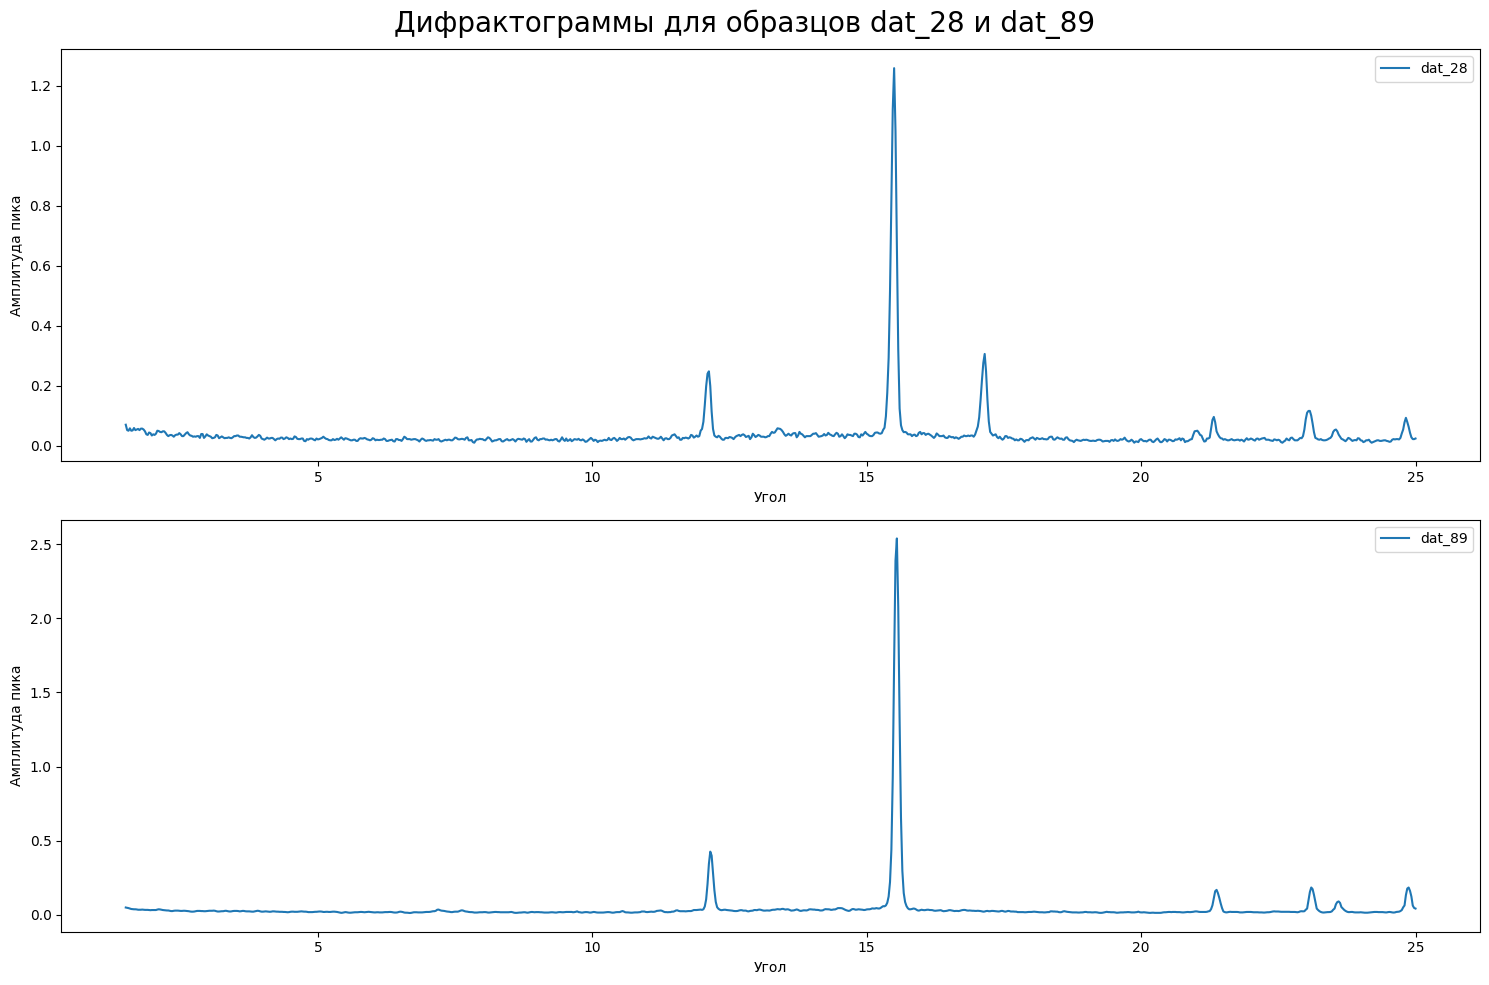

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].plot(angles, dat_28, label='dat_28')
axes[1].plot(angles, dat_89, label='dat_89')
for ax in axes:
    ax.set_ylabel('Амплитуда пика')
    ax.set_xlabel('Угол')
    ax.legend()
fig.suptitle('Дифрактограммы для образцов dat_28 и dat_89', size=20) 
fig.tight_layout()

Найдем пики по условию максимума и отобразим их на дифрактограммах

In [6]:
peaks28, _ = find_peaks(dat_28, prominence=0.035) 
peaks89, _ = find_peaks(dat_89, prominence=0.05) 

In [7]:
peaks28

array([425, 560, 626, 781, 793, 862, 882, 933])

In [8]:
peaks89

array([426, 562, 795, 864, 884, 935])

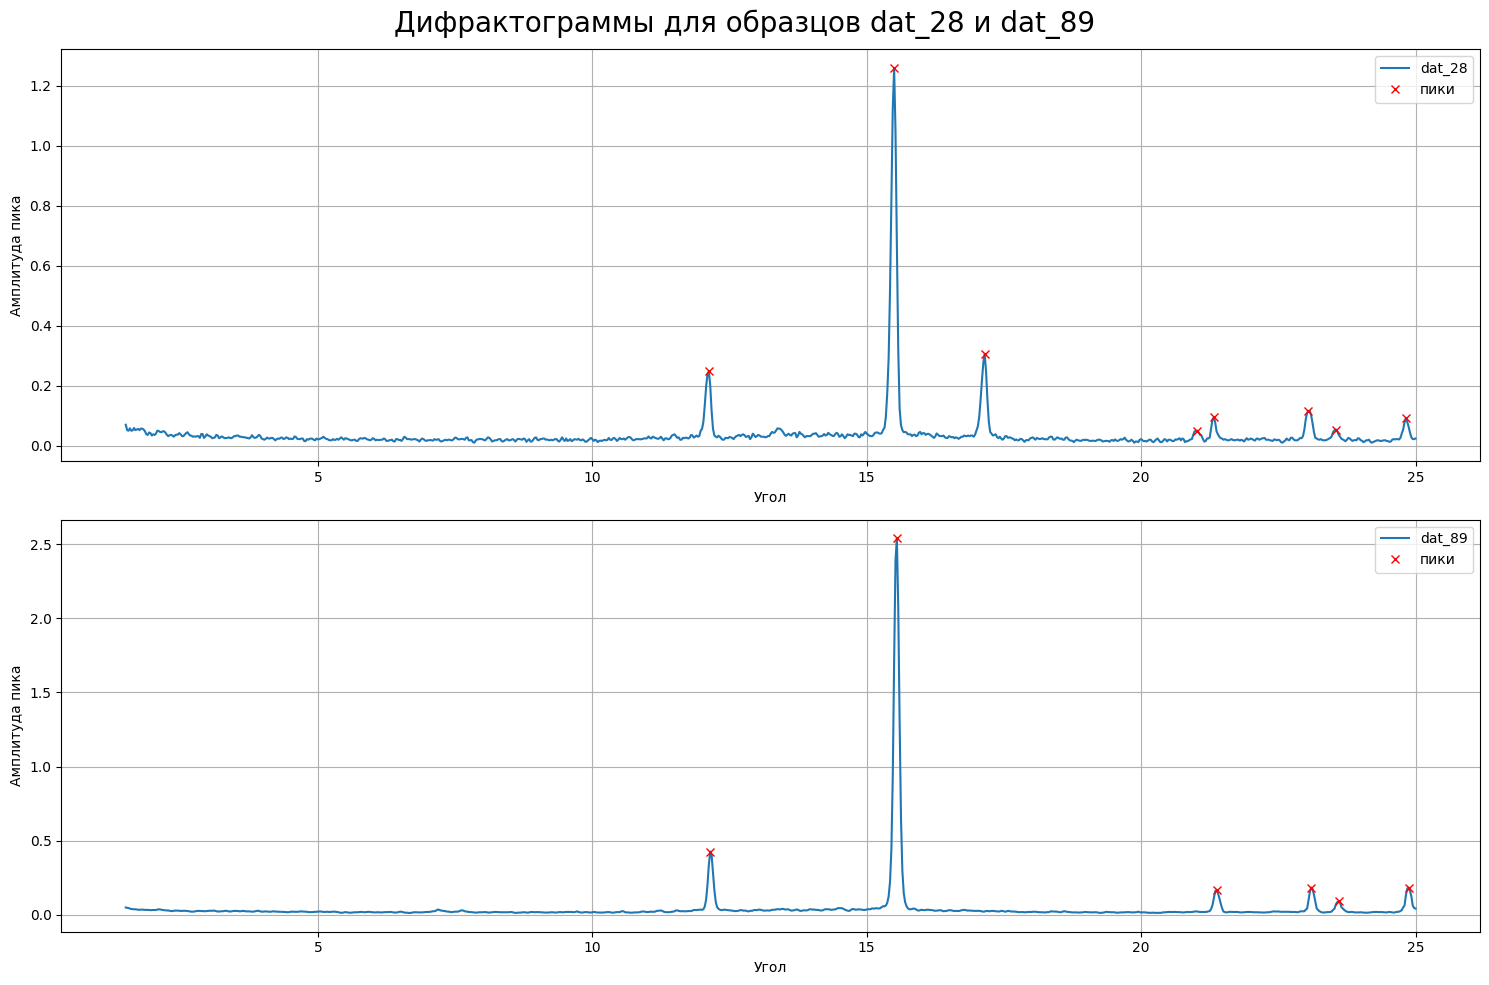

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(angles, dat_28, label='dat_28')
axes[0].plot(angles[peaks28], dat_28[peaks28], "xr", label='пики')

axes[1].plot(angles, dat_89, label='dat_89')
axes[1].plot(angles[peaks89], dat_89[peaks89], "xr", label='пики')
for ax in axes:
    ax.set_ylabel('Амплитуда пика')
    ax.set_xlabel('Угол')
    ax.legend()
    ax.grid()
fig.suptitle('Дифрактограммы для образцов dat_28 и dat_89', size=20) 
fig.tight_layout()

Удалим фон методом отрезка

In [10]:
def remove_background(data, zone_size, eps = 1e-5):
    n = len(data)

    background = np.zeros_like(data)

    for i in range(n - zone_size):
        start = data[i]
        end = data[i + zone_size - 1]
        segment = np.linspace(start, end, zone_size)
        part_spectrum = data[i : i + zone_size]
        background[i: i + zone_size] = np.minimum(segment, part_spectrum)


    return data - background
        

In [11]:
dat_28_wo_bg = remove_background(dat_28, 900)
dat_89_wo_bg =  remove_background(dat_89, 900)

Изобразим данные с фоном и без фона

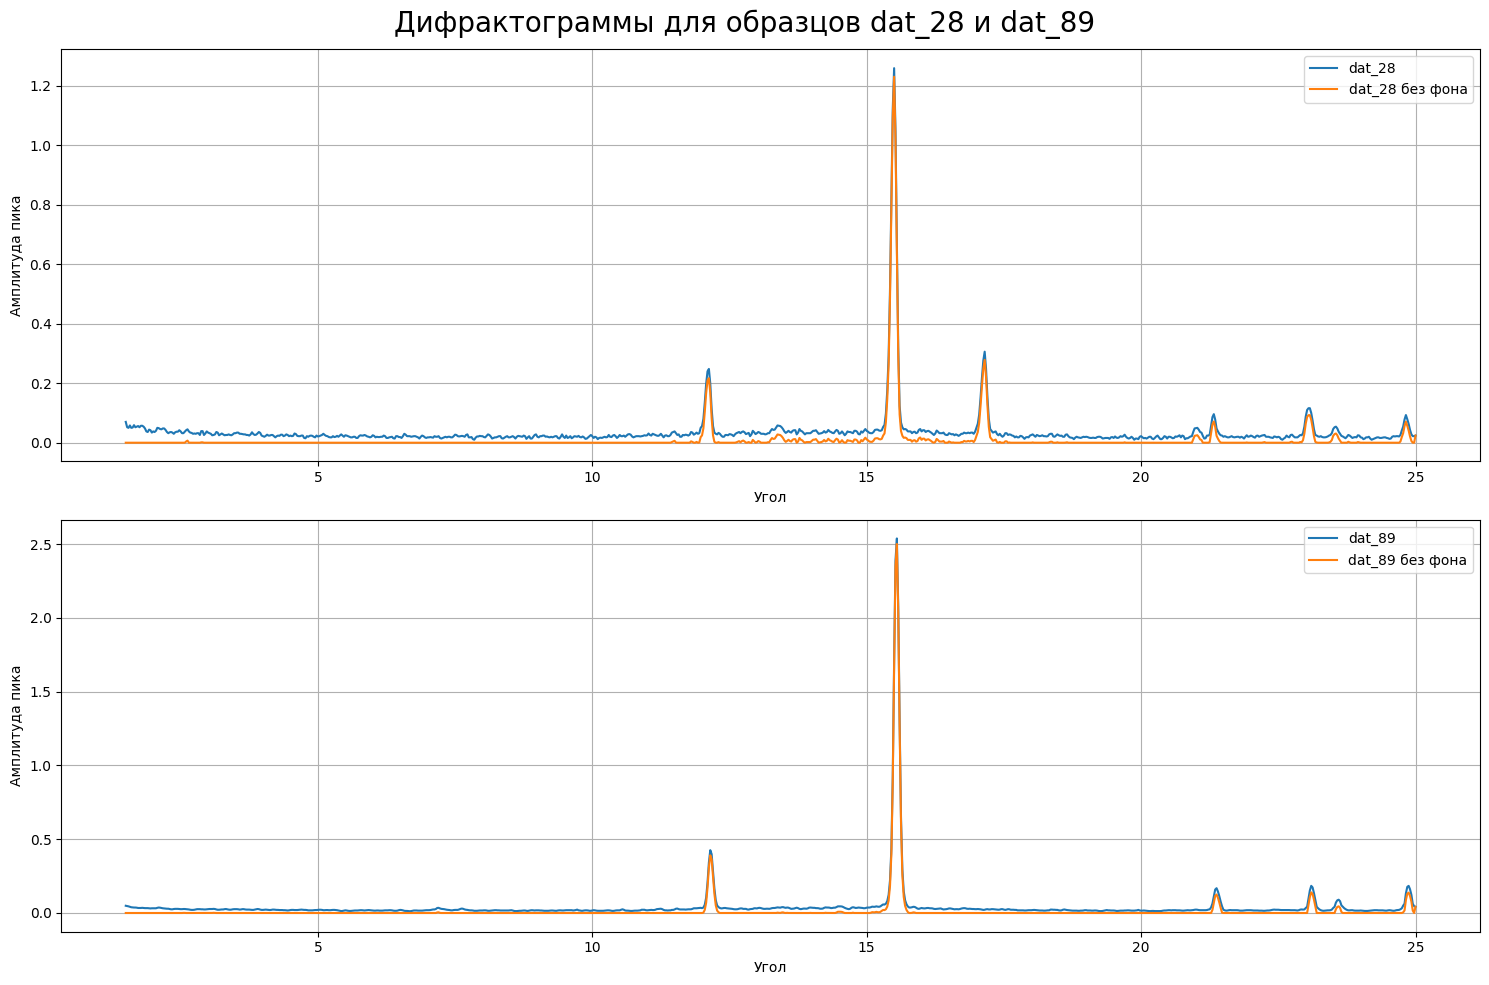

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(angles, dat_28, label='dat_28')
axes[0].plot(angles, dat_28_wo_bg, label='dat_28 без фона')

axes[1].plot(angles, dat_89, label='dat_89')
axes[1].plot(angles, dat_89_wo_bg, label='dat_89 без фона')
for ax in axes:
    ax.set_ylabel('Амплитуда пика')
    ax.set_xlabel('Угол')
    ax.legend()

    ax.grid()
fig.suptitle('Дифрактограммы для образцов dat_28 и dat_89', size=20) 
fig.tight_layout()

Определим положение пика по "шаблону"

За эталон пика возьмем самый высокий пик. С ним будем коррелировать все остальные пики. 

In [13]:
template_pick_28 = dat_28_wo_bg[peaks28[1] - 10 : peaks28[1] + 10]
angles_pick_28 = angles[peaks28[1] - 10 : peaks28[1] + 10]

template_pick_89 = dat_89_wo_bg[peaks89[1] - 10 : peaks89[1] + 10]
angles_pick_89 = angles[peaks89[1] - 10 : peaks89[1] + 10]


Изобразим выбранные пики для наших данных

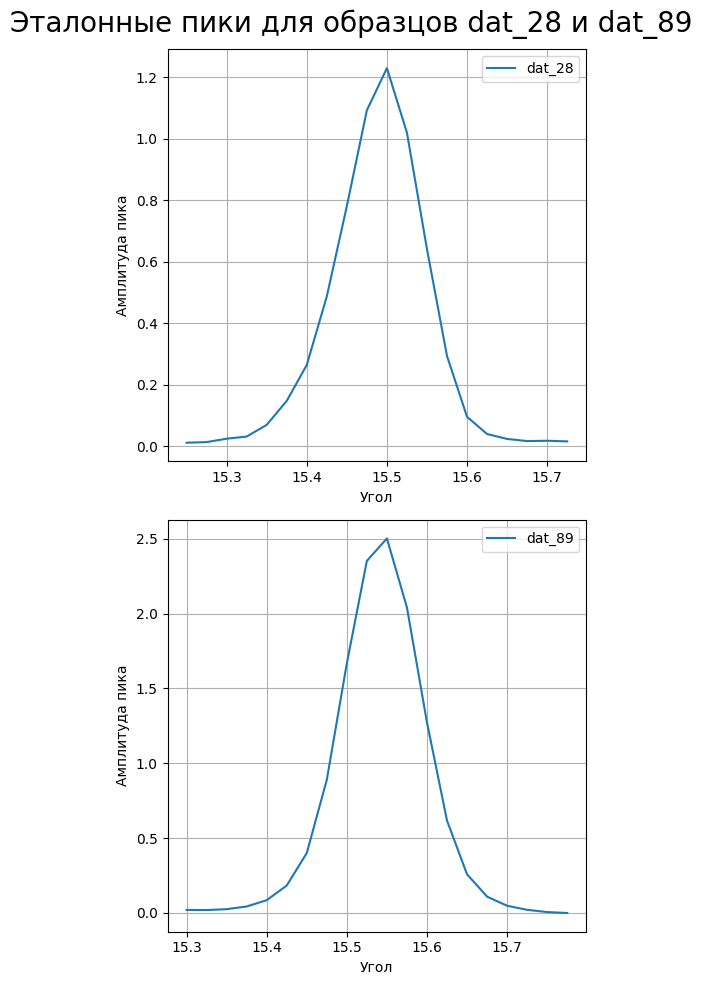

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

axes[0].plot(angles_pick_28, template_pick_28, label='dat_28')

axes[1].plot(angles_pick_89, template_pick_89, label='dat_89')

for ax in axes:
    ax.set_ylabel('Амплитуда пика')
    ax.set_xlabel('Угол')
    ax.legend()

    ax.grid()
fig.suptitle('Эталонные пики для образцов dat_28 и dat_89', size=20) 
fig.tight_layout()

Найдем корреляцию между эталонным пиком и фактическими данными

In [17]:
correlation_result_28 = np.correlate(dat_28, template_pick_28, mode='full')[template_pick_28.shape[0]-1:]
correlation_result_89 = np.correlate(dat_89, template_pick_89, mode='full')[template_pick_89.shape[0]-1:]

Оставим точки с высокой корреляцией

In [64]:
mask_28 = (correlation_result_28 > 0.25)
mask_89 = (correlation_result_89 > 0.6)
mask_28[0:28] = False

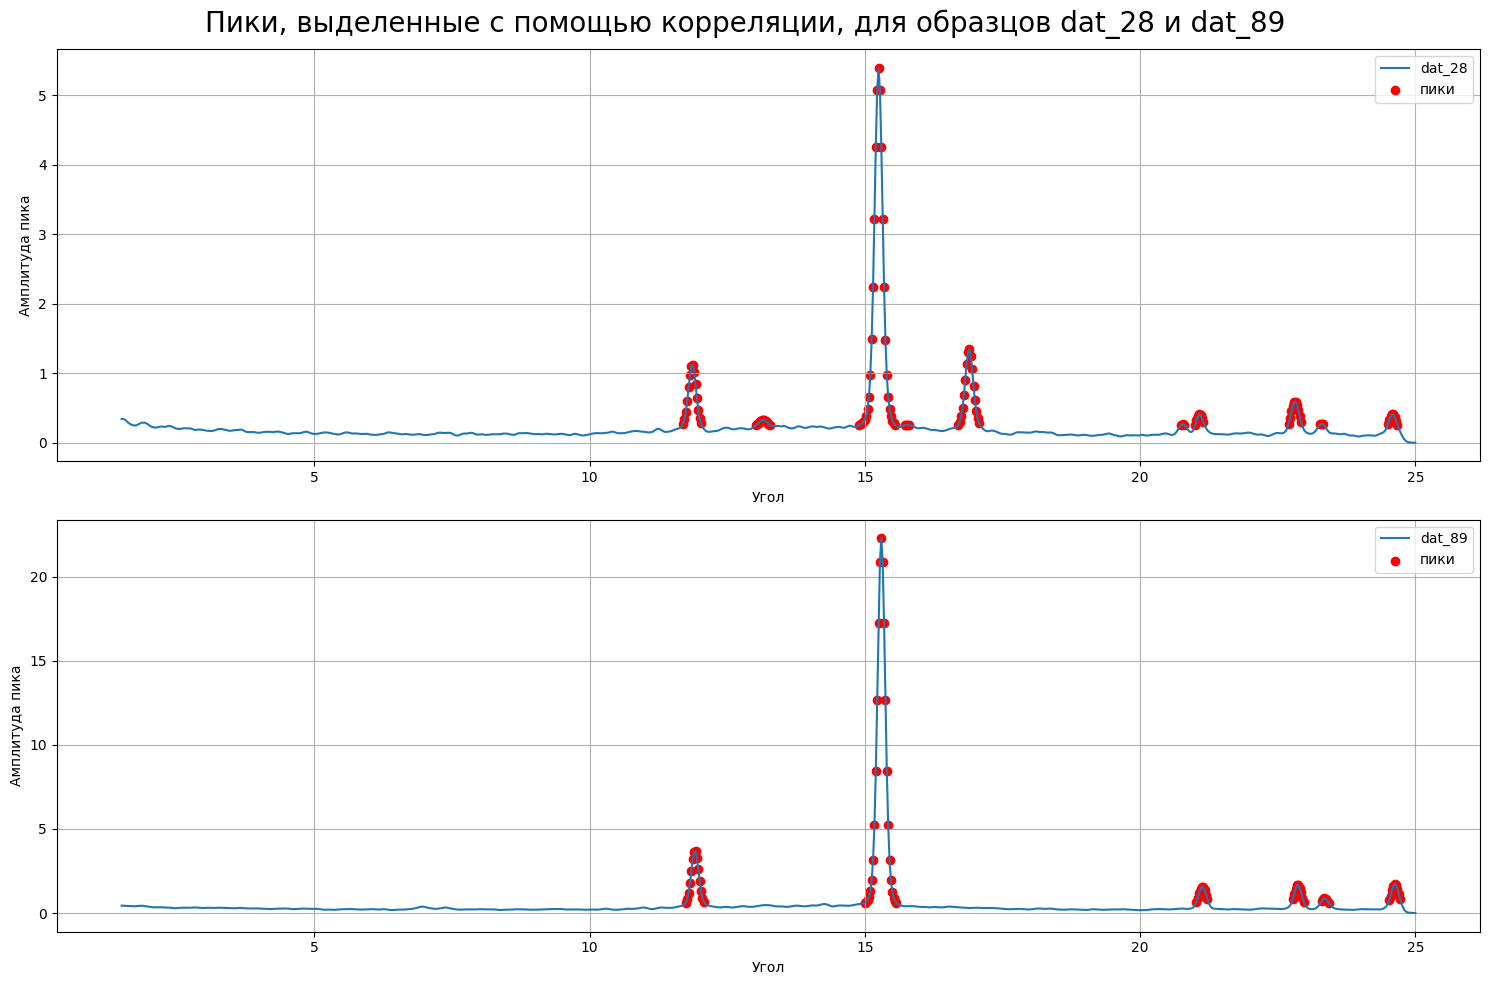

In [66]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(angles, correlation_result_28, label='dat_28')
axes[0].scatter(angles[mask_28], correlation_result_28[mask_28], color='r', label='пики')

axes[1].plot(angles, correlation_result_89, label='dat_89')
axes[1].scatter(angles[mask_89], correlation_result_89[mask_89], color='r', label='пики')

for ax in axes:
    ax.set_ylabel('Амплитуда пика')
    ax.set_xlabel('Угол')
    ax.legend()
    ax.grid()
fig.suptitle('Пики, выделенные с помощью корреляции, для образцов dat_28 и dat_89', size=20) 
fig.tight_layout()